In [79]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


In [80]:
DATA = 'Desktop/Synattack.xlsx'
dataset = pd.read_excel('Desktop/Synattack.xlsx')

In [81]:
dataset.columns

Index(['Time', 'SynAttack'], dtype='object')

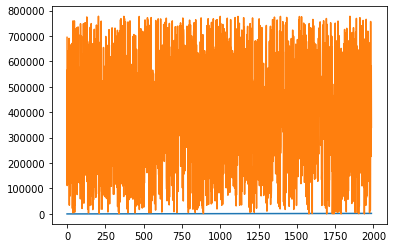

In [82]:
plt.plot(dataset)

In [83]:
datas = dataset
datas

,Time,SynAttack
0,1,694476
1,2,111530
2,3,566374
3,4,411851
4,5,516526
...,...,...
1983,1984,225304
1984,1985,416729
1985,1986,296445
1986,1987,582938


In [84]:
datas.columns

Index(['Time', 'SynAttack'], dtype='object')

In [85]:
newfloatdataset = datas['SynAttack'].values.astype(float)

In [86]:
newfloatdataset

array([694476., 111530., 566374., ..., 296445., 582938., 340738.])

In [87]:
train_data = newfloatdataset[:int(len(newfloatdataset)*0.7)]

In [88]:
test_data = newfloatdataset[int(len(newfloatdataset)*0.7):]

In [89]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [90]:
train_data_normalized

array([[ 0.78628005],
       [-0.71554846],
       [ 0.45625423],
       ...,
       [ 0.85213734],
       [-0.04971822],
       [-0.70416648]])

In [91]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [92]:
trainday=7
def create_sequences(input_data, trainday=7):
    inout_seq = []
    L = len(input_data)
    for i in range(L-trainday):
        train_seq = input_data[i:i+trainday]
        train_label = input_data[i+trainday:i+trainday+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [93]:
train_inout_seq = create_sequences(train_data_normalized, trainday=7)

In [94]:
train_inout_seq

[(tensor([ 0.7863, -0.7155,  0.4563,  0.0582,  0.3278,  0.3874, -0.3752]),
  tensor([0.6465])),
 (tensor([-0.7155,  0.4563,  0.0582,  0.3278,  0.3874, -0.3752,  0.6465]),
  tensor([0.1416])),
 (tensor([ 0.4563,  0.0582,  0.3278,  0.3874, -0.3752,  0.6465,  0.1416]),
  tensor([-0.7007])),
 (tensor([ 0.0582,  0.3278,  0.3874, -0.3752,  0.6465,  0.1416, -0.7007]),
  tensor([-0.3289])),
 (tensor([ 0.3278,  0.3874, -0.3752,  0.6465,  0.1416, -0.7007, -0.3289]),
  tensor([0.4769])),
 (tensor([ 0.3874, -0.3752,  0.6465,  0.1416, -0.7007, -0.3289,  0.4769]),
  tensor([0.0471])),
 (tensor([-0.3752,  0.6465,  0.1416, -0.7007, -0.3289,  0.4769,  0.0471]),
  tensor([0.7760])),
 (tensor([ 0.6465,  0.1416, -0.7007, -0.3289,  0.4769,  0.0471,  0.7760]),
  tensor([-0.0857])),
 (tensor([ 0.1416, -0.7007, -0.3289,  0.4769,  0.0471,  0.7760, -0.0857]),
  tensor([-0.9146])),
 (tensor([-0.7007, -0.3289,  0.4769,  0.0471,  0.7760, -0.0857, -0.9146]),
  tensor([0.1945])),
 (tensor([-0.3289,  0.4769,  0.0471,

In [95]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=80, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_size),
                            torch.zeros(1,1,self.hidden_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [96]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [97]:
print(model)

LSTM(
  (lstm): LSTM(1, 80)
  (linear): Linear(in_features=80, out_features=1, bias=True)
)


In [98]:
TP=0
TN=0
FN=0
FP=0


In [99]:
for i in range(300):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))

        y_pred = model(seq)
        #_, predicted = torch.max(y_pred.data, 1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum()
        
        #accuracy = 100 * correct / total

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
        #TP += ((y_pred == 1) & (labels.data == 1)).sum()
        #TN += ((y_pred == 0) & (labels.data == 0)).sum()
        #FN += ((y_pred == 0) & (labels.data == 1)).sum()
        #FP += ((y_pred == 1) & (labels.data == 0)).sum()
        #acc = (TP + TN) / (TP + TN + FP + FN)

    if i%25 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        #print(acc)
                                                                                            
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   0 loss: 0.47676781
epoch:  25 loss: 0.52673542
epoch:  50 loss: 0.48317653
epoch:  75 loss: 0.54852331
epoch: 100 loss: 0.31393695
epoch: 125 loss: 0.00729690
epoch: 150 loss: 0.04170751
epoch: 175 loss: 0.02348422
epoch: 200 loss: 0.13706234
epoch: 225 loss: 0.00982503
epoch: 250 loss: 0.00869310
epoch: 275 loss: 0.00166051
epoch: 299 loss: 0.0003042188


In [100]:
model.eval()

LSTM(
  (lstm): LSTM(1, 80)
  (linear): Linear(in_features=80, out_features=1, bias=True)
)

In [101]:
#test_inputs = train_data_normalized[-int(len(newfloatdataset)*0.4):].tolist()

In [102]:
test_inputs = train_data_normalized[-7:].tolist()

In [103]:
print(test_inputs)

[-0.928621768951416, -0.6937248706817627, 0.45233315229415894, 0.3541436195373535, 0.8521373271942139, -0.0497182197868824, -0.7041664719581604]


In [104]:
fut_pred=7
for i in range(fut_pred):
    seq = torch .FloatTensor(test_inputs[-trainday:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        test_inputs.append(model(seq).item())

In [105]:
test_inputs[fut_pred:]

[-0.8149474263191223,
 -0.5429161787033081,
 -0.2256741225719452,
 -0.3010460138320923,
 -0.04788532108068466,
 -0.890424907207489,
 0.028829947113990784]

In [106]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[trainday:] ).reshape(-1, 1))
print(actual_predictions)

[[ 72947.54436854]
 [178538.51336497]
 [301678.39676778]
 [272422.23188597]
 [370688.45348262]
 [ 43650.39408061]
 [400466.0601969 ]]


In [107]:
actual_predictions.size

7

In [108]:
x = np.arange(1981, 1988, 1)

In [109]:
print(x)

[1981 1982 1983 1984 1985 1986 1987]


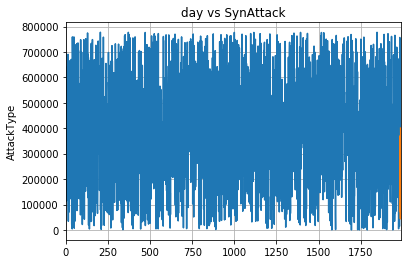

In [110]:
plt.title('day vs SynAttack')
plt.ylabel('AttackType')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(dataset['SynAttack'])
plt.plot(x,actual_predictions)
plt.show()

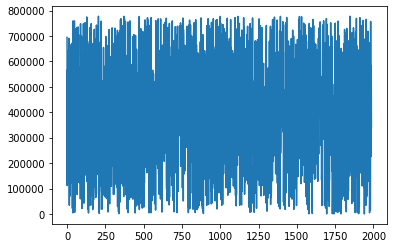

In [111]:
plt.plot(dataset['SynAttack'])

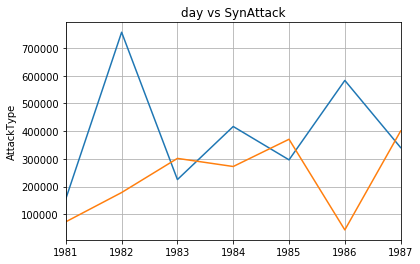

In [112]:
plt.title('day vs SynAttack')
plt.ylabel('AttackType')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(dataset['SynAttack'][1981:])
plt.plot(x,actual_predictions)
plt.show()

In [ ]:
TP

In [ ]:
#def accuracy_score(y_true, actual_predictions):
    #actual_predictions = np.concatenate(tuple(actual_predictions))
    #y_true = np.concatenate(tuple([[t for t in y] for y in y_true])).reshape(actual_predictions.shape)
    #return (y_true == actual_predictions).sum() / float(len(y_true))

In [ ]:
#actual_predictions = list(predict([s for s, t in training_data]))
#y_true = [t for s, t in training_data]
#numpy accuracy score
#print(accuracy_score(y_true, y_pred))